# Predicción del ingreso bruto obtenido por una película mediante diferentes modelos de Machine Learning.

# Dataset:

### TMDB 5000 Movie Dataset:
- https://www.kaggle.com/tmdb/tmdb-movie-metadata


## Variable objetivo:  
### Gross:  cuanto generó la película de ingreso bruto (gross income)

## Importar librerías

In [1]:
import numpy as np
import pandas as pd
import sklearn

# Imputer
from sklearn.impute import SimpleImputer

# Data
from sklearn.model_selection import train_test_split

# Grid y random para buscar el mejor modelo
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Modelos
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# Medidas del error
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, plot_roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, confusion_matrix

# Visualización
from IPython.display import Image as PImage
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# librería para visualizar grafos
from sklearn.tree import export_graphviz
from subprocess import check_call

## Importar los datos y obtener información sobre el dataset

In [2]:
df_movies = pd.read_csv(r'peliculas.csv')
df_movies.head()

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
0,Avatar,2009.0,Color,1.78,178.0,English,USA,178.0,Action|Adventure|Fantasy|Sci-Fi,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,4834,237000000.0,7.9,760505847.0
1,Pirates of the Caribbean: At World's End,2007.0,Color,2.35,169.0,English,USA,169.0,Action|Adventure|Fantasy,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,48350,300000000.0,7.1,309404152.0
2,Spectre,2015.0,Color,2.35,148.0,English,UK,148.0,Action|Adventure|Thriller,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11700,245000000.0,6.8,200074175.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,English,USA,164.0,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Documentary,NaN,NaN,Doug Walker,Doug Walker,Rob Walker,NaN,143,NaN,7.1,NaN


In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                5043 non-null   object 
 1   title_year                 4935 non-null   float64
 2   color                      5024 non-null   object 
 3   aspect_ratio               4714 non-null   float64
 4   duration                   5028 non-null   float64
 5   language                   5031 non-null   object 
 6   country                    5038 non-null   object 
 7   duration.1                 5028 non-null   float64
 8   genres                     5043 non-null   object 
 9   content_rating             4740 non-null   object 
 10  plot_keywords              4890 non-null   object 
 11  director_name              4939 non-null   object 
 12  actor_1_name               5036 non-null   object 
 13  actor_2_name               5030 non-null   objec

### Separar los valores numéricos y los caracteres

In [4]:
# caracteres
strings = df_movies.dtypes == object
str_col = [string for string in strings.index if strings[string]]
movies_str = df_movies[str_col]

movies_str.head()

,movie_title,color,language,country,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name
0,Avatar,Color,English,USA,Action|Adventure|Fantasy|Sci-Fi,PG-13,avatar|future|marine|native|paraplegic,James Cameron,CCH Pounder,Joel David Moore,Wes Studi
1,Pirates of the Caribbean: At World's End,Color,English,USA,Action|Adventure|Fantasy,PG-13,goddess|marriage ceremony|marriage proposal|pi...,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport
2,Spectre,Color,English,UK,Action|Adventure|Thriller,PG-13,bomb|espionage|sequel|spy|terrorist,Sam Mendes,Christoph Waltz,Rory Kinnear,Stephanie Sigman
3,The Dark Knight Rises,Color,English,USA,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt
4,Star Wars: Episode VII - The Force Awakens ...,NaN,NaN,NaN,Documentary,NaN,NaN,Doug Walker,Doug Walker,Rob Walker,NaN


### Para este análisis se dará prioridad a los valores numéricos dado que estos aportan mayor información cuantitativa 

In [5]:
# numéricos:
numbers = (df_movies.dtypes == float) | (df_movies.dtypes == int)
num_col = [num for num in numbers.index if numbers[num]]
movies_num = df_movies[num_col]

movies_num.head()

,title_year,aspect_ratio,duration,duration.1,budget,imdb_score,gross
0,2009.0,1.78,178.0,178.0,237000000.0,7.9,760505847.0
1,2007.0,2.35,169.0,169.0,300000000.0,7.1,309404152.0
2,2015.0,2.35,148.0,148.0,245000000.0,6.8,200074175.0
3,2012.0,2.35,164.0,164.0,250000000.0,8.5,448130642.0
4,NaN,NaN,NaN,NaN,NaN,7.1,NaN


## Estadísticos principales

In [6]:
movies_num.describe()

,title_year,aspect_ratio,duration,duration.1,budget,imdb_score,gross
count,4935.000000,4714.000000,5028.000000,5028.000000,4.551000e+03,5043.000000,4.159000e+03
mean,2002.470517,2.220403,107.201074,107.201074,3.975262e+07,6.442138,4.846841e+07
std,12.474599,1.385113,25.197441,25.197441,2.061149e+08,1.125116,6.845299e+07
min,1916.000000,1.180000,7.000000,7.000000,2.180000e+02,1.600000,1.620000e+02
25%,1999.000000,1.850000,93.000000,93.000000,6.000000e+06,5.800000,5.340988e+06
50%,2005.000000,2.350000,103.000000,103.000000,2.000000e+07,6.600000,2.551750e+07
75%,2011.000000,2.350000,118.000000,118.000000,4.500000e+07,7.200000,6.230944e+07
max,2016.000000,16.000000,511.000000,511.000000,1.221550e+10,9.500000,7.605058e+08


array([[<AxesSubplot:title={'center':'title_year'}>,
        <AxesSubplot:title={'center':'aspect_ratio'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'duration.1'}>,
        <AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'imdb_score'}>],
       [<AxesSubplot:title={'center':'gross'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

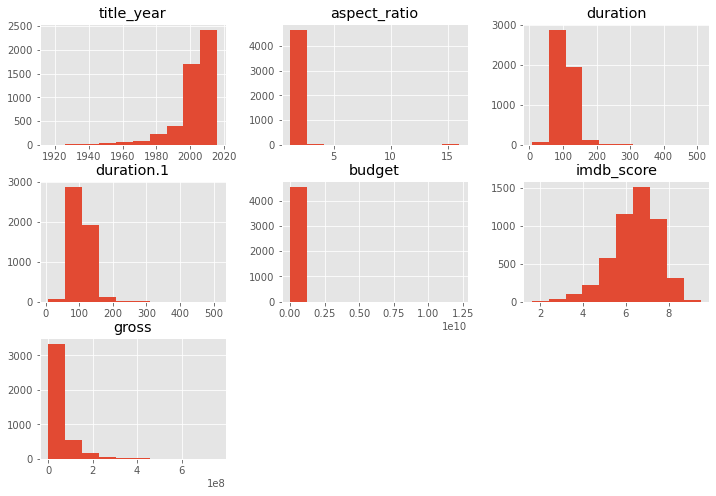

In [7]:
movies_num.hist()

### Analizando los estadísticos, se evidencia que en la columna de Budget (presupuesto) existen algunos datos atípicos, como por ejemplo alguna película con un presupuesto de 1.221550e+10, se procede a contar y analizar cuantas y cuales peliculas superan mil millones de dolares de presupuesto.

In [8]:
(movies_num['budget'] > 1e9).value_counts()

False    5037
True        6
Name: budget, dtype: int64

In [9]:
expensive_budget_movies = movies_num['budget'] > 1e9
df_movies[expensive_budget_movies]

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
2323,Princess Mononoke,1997.0,Color,1.85,134.0,Japanese,Japan,134.0,Adventure|Animation|Fantasy,PG-13,anime|cult film|forest|princess|studio ghibli,Hayao Miyazaki,Minnie Driver,Jada Pinkett Smith,Billy Crudup,2710,2.400000e+09,8.4,2298191.0
2334,Steamboy,2004.0,Color,1.85,103.0,Japanese,Japan,103.0,Action|Adventure|Animation|Family|Sci-Fi|Thriller,PG-13,19th century|ball|boy|inventor|steam,Katsuhiro Ôtomo,William Hootkins,Robin Atkin Downes,Rosalind Ayres,991,2.127520e+09,6.9,410388.0
2988,The Host,2006.0,Color,1.85,110.0,Korean,South Korea,110.0,Comedy|Drama|Horror|Sci-Fi,R,daughter|han river|monster|river|seoul,Joon-ho Bong,Doona Bae,Kang-ho Song,Ah-sung Ko,1173,1.221550e+10,7.0,2201412.0
3005,Fateless,2005.0,Color,2.35,134.0,Hungarian,Hungary,134.0,Drama|Romance|War,R,bus|death|gay slur|hatred|jewish,Lajos Koltai,Marcell Nagy,Péter Fancsikai,Bálint Péntek,11,2.500000e+09,7.1,195888.0
3423,Akira,1988.0,Color,1.85,124.0,Japanese,Japan,124.0,Action|Animation|Sci-Fi,R,based on manga|biker gang|gifted child|post th...,Katsuhiro Ôtomo,Mitsuo Iwata,Takeshi Kusao,Tesshô Genda,28,1.100000e+09,8.1,439162.0
3859,Lady Vengeance,2005.0,Color,2.35,112.0,Korean,South Korea,112.0,Crime|Drama,R,cake|christian|lesbian sex|oral sex|pregnant s...,Chan-wook Park,Min-sik Choi,Yeong-ae Lee,Hye-jeong Kang,907,4.200000e+09,7.7,211667.0


### Al consultar estos datos en wikipedia, resulta que los precios están en moneda japonesa y koreana respectivamente, todos los valores deben estar en dólares, por esta razón algunos datos fueron mal obtenidos.

### Una posible solución a este problema es en encontrar información confiable acerca de las variables financieras con las que se está trabajando:

- production_budget : presupuesto de producción
- worldwide_gross :  ingreso mundial

# Dataset que tiene los datos correctos obtenido desde la página  https://www.the-numbers.com/

In [10]:
df_num_col_movies = pd.read_csv(r'the_numbers.csv')
df_num_col_movies.head()

,Unnamed: 0,movie_name,domestic_gross,movie_link,production_budget,release_date,worldwide_gross,movie_title
0,0,Avatar,760507625,http://www.the-numbers.com/movie/Avatar#tab=su...,425000000,12/18/2009,2783918982,Avatar
1,1,Star Wars Ep. VII: The Force Awakens,936662225,http://www.the-numbers.com/movie/Star-Wars-Ep-...,306000000,12/18/2015,2058662225,Star Wars: Episode VII - The Force Awakens ...
2,2,Pirates of the Caribbean: At World's End,309420425,http://www.the-numbers.com/movie/Pirates-of-th...,300000000,5/24/2007,963420425,Pirates of the Caribbean: At World's End
3,3,Spectre,200074175,http://www.the-numbers.com/movie/Spectre#tab=s...,300000000,11/6/2015,879620923,Spectre
4,4,The Dark Knight Rises,448139099,http://www.the-numbers.com/movie/Dark-Knight-R...,275000000,7/20/2012,1084439099,The Dark Knight Rises


In [11]:
df_financial_data = df_num_col_movies[['movie_title', 'production_budget', 'worldwide_gross']]

## Analizar datos en común entre ambos datasets

In [12]:
print('\nPeliculas tiene {} datos, mientras que el dataset obtenido de the_numbers.com tiene {} datos \n'.format(df_movies.shape[0], df_financial_data.shape[0]))
print('Cantidad de datos perdidos: ', df_movies.shape[0] - df_financial_data.shape[0])


Peliculas tiene 5043 datos, mientras que el dataset obtenido de the_numbers.com tiene 4341 datos 

Cantidad de datos perdidos:  702


### Se pierden muchos datos, al rededor de un 14%, sin embargo es mejor tener datos de calidad en el dataset

# Construcción del nuevo dataset con datos de mejor calidad

In [13]:
# Preparamos el dataset movies_num para que el key sea movie_title

df_movies_num = pd.concat([movies_num, df_movies['movie_title']], axis=1)
df_movies_num.head()

,title_year,aspect_ratio,duration,duration.1,budget,imdb_score,gross,movie_title
0,2009.0,1.78,178.0,178.0,237000000.0,7.9,760505847.0,Avatar
1,2007.0,2.35,169.0,169.0,300000000.0,7.1,309404152.0,Pirates of the Caribbean: At World's End
2,2015.0,2.35,148.0,148.0,245000000.0,6.8,200074175.0,Spectre
3,2012.0,2.35,164.0,164.0,250000000.0,8.5,448130642.0,The Dark Knight Rises
4,NaN,NaN,NaN,NaN,NaN,7.1,NaN,Star Wars: Episode VII - The Force Awakens ...


In [14]:
# El "on" indica la llave con la que hice el join, el "how" significa el largo de los datos que quiero usar, 
# izquierdo para el dato de la izquierda -- financial , o derecho para el dato de la derecha -- movies

df_movies_num_clean = pd.merge(df_financial_data, df_movies_num, on='movie_title', how='left')
df_movies_num_clean.head()

,movie_title,production_budget,worldwide_gross,title_year,aspect_ratio,duration,duration.1,budget,imdb_score,gross
0,Avatar,425000000,2783918982,2009.0,1.78,178.0,178.0,237000000.0,7.9,760505847.0
1,Star Wars: Episode VII - The Force Awakens ...,306000000,2058662225,NaN,NaN,NaN,NaN,NaN,7.1,NaN
2,Pirates of the Caribbean: At World's End,300000000,963420425,2007.0,2.35,169.0,169.0,300000000.0,7.1,309404152.0
3,Spectre,300000000,879620923,2015.0,2.35,148.0,148.0,245000000.0,6.8,200074175.0
4,The Dark Knight Rises,275000000,1084439099,2012.0,2.35,164.0,164.0,250000000.0,8.5,448130642.0


### Duration y duration.1 son columnas repetidas, entonces se elimina una

In [15]:
df_movies_num_clean= df_movies_num_clean.drop('duration.1', axis=1)

### Trabajar solo con datos numéricos, se debe eliminar el nombre de la película.

In [16]:
df_movies_num_clean= df_movies_num_clean.drop('movie_title', axis=1)

## Limpieza de datos, analizando datos faltantes y nulos.

In [17]:
df_movies_num_clean.notnull().apply(pd.Series.value_counts)

,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
False,NaN,NaN,27,274,13,335,NaN,671
True,4385.0,4385.0,4358,4111,4372,4050,4385.0,3714


In [18]:
(df_movies_num_clean != 0).apply(pd.Series.value_counts)

,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
False,NaN,281,NaN,NaN,NaN,NaN,NaN,NaN
True,4385.0,4104,4385.0,4385.0,4385.0,4385.0,4385.0,4385.0


### Observar cuantos datos en total son cero o están vacíos

In [19]:
avaliable = ((df_movies_num_clean != 0) & (df_movies_num_clean.notnull()) )
avaliable.all(axis=1).value_counts()

True     3413
False     972
dtype: int64

### 972 es una cantidad muy grande de datos para simplemente ser eliminada, por esta razón se debe hacer uso de técnicas como rellenar valores mediante normalizacion:
${Valor} = ({x}-{μ})/{σ}$ 

### Una variable bastante importante para la predicción es "worldwide gross" : ingreso mundial , por esta razón se usará la función " Imputer " de sklearn para rellenar los ceros en esta.

In [20]:
worldwide_gross_avaliable = avaliable['worldwide_gross']
df_movies_num_clean = df_movies_num_clean[worldwide_gross_avaliable]

df_movies_num_clean.head()


,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
0,425000000,2783918982,2009.0,1.78,178.0,237000000.0,7.9,760505847.0
1,306000000,2058662225,NaN,NaN,NaN,NaN,7.1,NaN
2,300000000,963420425,2007.0,2.35,169.0,300000000.0,7.1,309404152.0
3,300000000,879620923,2015.0,2.35,148.0,245000000.0,6.8,200074175.0
4,275000000,1084439099,2012.0,2.35,164.0,250000000.0,8.5,448130642.0


In [21]:
# Imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

numpy_array_values = imputer.fit_transform(df_movies_num_clean)


# Recontrucción del Dataset sin ceros y NaN

In [22]:
# Ahora en este array fueron eliminados todos los ceros y los NAN que se tenían
df_clean_movies = pd.DataFrame(numpy_array_values)

df_clean_movies.columns = df_movies_num_clean.columns
df_clean_movies.index = df_movies_num_clean.index

df_clean_movies.head()

,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
0,425000000.0,2.783919e+09,2009.000000,1.780000,178.000000,2.370000e+08,7.9,7.605058e+08
1,306000000.0,2.058662e+09,2002.130733,2.126976,108.577186,4.045539e+07,7.1,4.831933e+07
2,300000000.0,9.634204e+08,2007.000000,2.350000,169.000000,3.000000e+08,7.1,3.094042e+08
3,300000000.0,8.796209e+08,2015.000000,2.350000,148.000000,2.450000e+08,6.8,2.000742e+08
4,275000000.0,1.084439e+09,2012.000000,2.350000,164.000000,2.500000e+08,8.5,4.481306e+08


In [23]:
(df_clean_movies != 0).apply(pd.Series.value_counts)

,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
True,4104,4104,4104,4104,4104,4104,4104,4104


In [24]:
df_clean_movies.notnull().apply(pd.Series.value_counts)

,production_budget,worldwide_gross,title_year,aspect_ratio,duration,budget,imdb_score,gross
True,4104,4104,4104,4104,4104,4104,4104,4104


# Ahora se procede a separar los datos y organizarlos para trabajar los modelos.

In [25]:
X = df_clean_movies.drop('worldwide_gross', axis=1)
y = df_clean_movies['worldwide_gross']

# separamos los datos en X,Y train con un 80% de los datos y en X,Y test con un 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Los datos para train son {} y para test son {}'.format(len(X_train), len(X_test)))

Los datos para train son 3283 y para test son 821


 # Primer modelo:
 ## Se ensaya una regresión Lasso.
 
- La regresión Lasso tiene la particularidad de realizar selección de variables en su proceso, al tener menos variables se puede lograr una mayor interpretabilidad.

In [26]:
# Parámetros a ensayar
alpha = np.arange(0.0001,0.01,0.0005)
tolerance = np.arange(0.0001,0.01,0.0005)
fit_intercept = [True, False]
normalize = [True, False]
positive = [True, False]
selection = ['cyclic', 'random']

parameters = {'alpha':alpha, 'tol':tolerance, 
              'fit_intercept':fit_intercept, 'normalize':normalize, 
              'positive':positive, 'selection':selection}

# Ensayando los parámetros en el modelo de regressión para obtener los más óptimos
model_lasso = GridSearchCV(Lasso(), parameters, cv=5, n_jobs=6)
model_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=6,
             param_grid={'alpha': array([0.0001, 0.0006, 0.0011, 0.0016, 0.0021, 0.0026, 0.0031, 0.0036,
       0.0041, 0.0046, 0.0051, 0.0056, 0.0061, 0.0066, 0.0071, 0.0076,
       0.0081, 0.0086, 0.0091, 0.0096]),
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'positive': [True, False],
                         'selection': ['cyclic', 'random'],
                         'tol': array([0.0001, 0.0006, 0.0011, 0.0016, 0.0021, 0.0026, 0.0031, 0.0036,
       0.0041, 0.0046, 0.0051, 0.0056, 0.0061, 0.0066, 0.0071, 0.0076,
       0.0081, 0.0086, 0.0091, 0.0096])})

### Obtener los mejores parámetros y entrenar el modelo con los mismos

In [27]:
model_lasso.best_params_

{'alpha': 0.004600000000000001,
 'fit_intercept': True,
 'normalize': True,
 'positive': True,
 'selection': 'random',
 'tol': 0.0086}

In [28]:
# Se construye la regresión con los parámetros obtenidos
model_regression = Lasso(alpha = model_lasso.best_params_['alpha'], 
                         tol = model_lasso.best_params_['tol'], 
                         #max_iter = model_lasso.best_params_['max_iter'],
                         fit_intercept = model_lasso.best_params_['fit_intercept'],
                         normalize = model_lasso.best_params_['normalize'],
                         positive = model_lasso.best_params_['positive'],
                         selection = model_lasso.best_params_['selection'])

model_regression.fit(X_train, y_train)

print('Entrenamiento de la regresión Lasso: ', model_regression)

Entrenamiento de la regresión Lasso:  Lasso(alpha=0.004600000000000001, normalize=True, positive=True,
      selection='random', tol=0.0086)


## Medidas del error para el modelo de regresión Lasso

In [29]:
def medida_error(y_pred, y_test, modelo):

    print('\nR2 Score: ', metrics.r2_score(y_test, y_pred))
    print('MSE: ', metrics.mean_squared_error(y_test, y_pred))

    # Entre 5 y 10 particiones del fold, arroja un resultado de validación bastante aproximado
    results = cross_val_score(modelo, X, y, cv=5, scoring='r2')
    print('Cross Validation Scores: ', results)
    print('Promedio Cross Validation Score: ', np.mean(results), '\n')

    # Mirar un histograma para comparar entre los valores reales y las predicciones
    plt.hist([y_pred, y_test], label=["prediccion", "real"], edgecolor='black', linewidth=1.2, alpha=0.9)
    plt.title('Comparación entre la prediccion y los valores reales')
    plt.legend(prop ={'size': 15})
    plt.show()
    
    # gráfica de la predicción
    sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100, "alpha":0.5, "color":'blue'}).set(title = 'Scatter de los puntos test y la regresión de predicción')
    plt.show()



R2 Score:  0.8844725292330279
MSE:  3236432530166034.5
Cross Validation Scores:  [ 0.72160107  0.750923    0.71038633  0.66559224 -0.82943357]
Promedio Cross Validation Score:  0.4038138111016044 



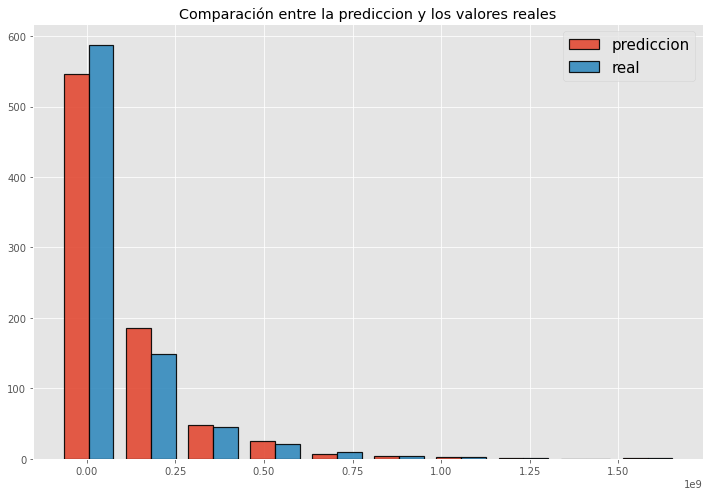

C:\Users\js-mu\anaconda3\envs\ia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


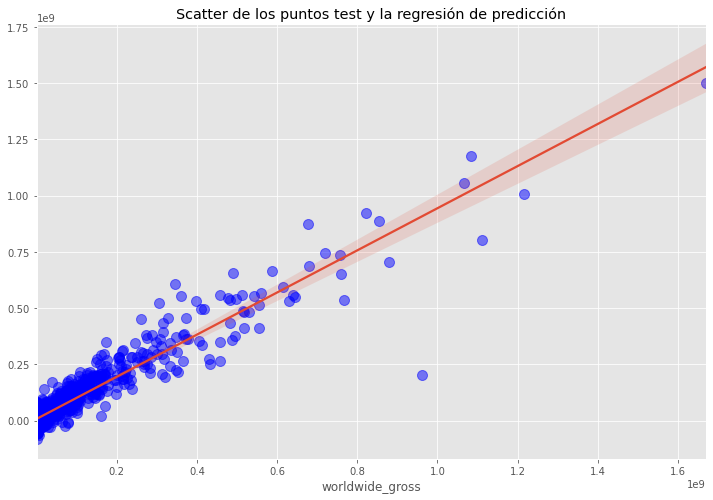

In [30]:
# Crear un vector de predicciones
y_pred_reg = model_regression.predict(X_test)

medida_error(y_pred_reg, y_test, model_regression)

# Segundo modelo:
## Familia de Árboles de decisión

- Se construye un arbol de decisión para la regresión
- Se implementa bagging mediante random forest
- Se implementa boosting mediante Gradient Boosting Regressor y el XGBoost

## Árbol de decisión

### Buscar los parámetros óptimos

In [31]:
# Parámetros a ensayar
parameters = {'min_samples_split':np.arange(3, 15),
              'min_samples_leaf':np.arange(3, 15),
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,100],
              'splitter':['best','random']}

# Ensayando los parámetros en el modelo de regressión para obtener los más óptimos
model_DT = GridSearchCV(DecisionTreeRegressor(), parameters, cv=5, n_jobs=6)
model_DT.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=6,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 100],
                         'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'splitter': ['best', 'random']})

In [32]:
model_DT.best_params_

{'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 13,
 'splitter': 'random'}

In [33]:
# Se construye el árbol de decisión con los parámetros obtenidos
model_DT = DecisionTreeRegressor(max_depth = model_DT.best_params_['max_depth'], 
                                 min_samples_split = model_DT.best_params_['min_samples_split'], 
                                 min_samples_leaf = model_DT.best_params_['min_samples_leaf'],
                                 splitter = model_DT.best_params_['splitter'])

model_DT.fit(X_train, y_train)

print('Entrenamiento del árbol de decisión: ', model_DT)

Entrenamiento del árbol de decisión:  DecisionTreeRegressor(max_depth=20, min_samples_leaf=3, min_samples_split=13,
                      splitter='random')


### Observar gráficamente el Árbol de Decisión

In [34]:
# Obtenemos una imagen del arbol calculado
# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f =      export_graphviz(model_DT,
                              out_file=f,
                              max_depth = 15,
                              impurity = True,
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

### Medidas del error para el modelo de Árbol de Decisión


R2 Score:  0.8509736495286391
MSE:  4174883474167813.0
Cross Validation Scores:  [0.51970255 0.58335465 0.68935184 0.70333782 0.50327988]
Promedio Cross Validation Score:  0.599805347836392 



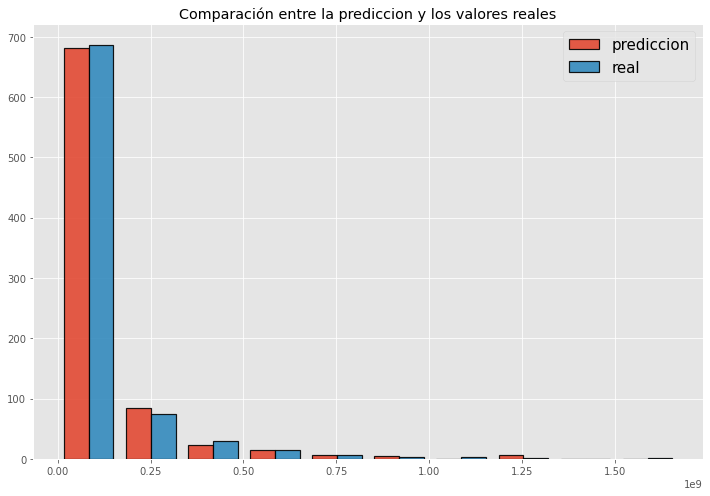

C:\Users\js-mu\anaconda3\envs\ia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


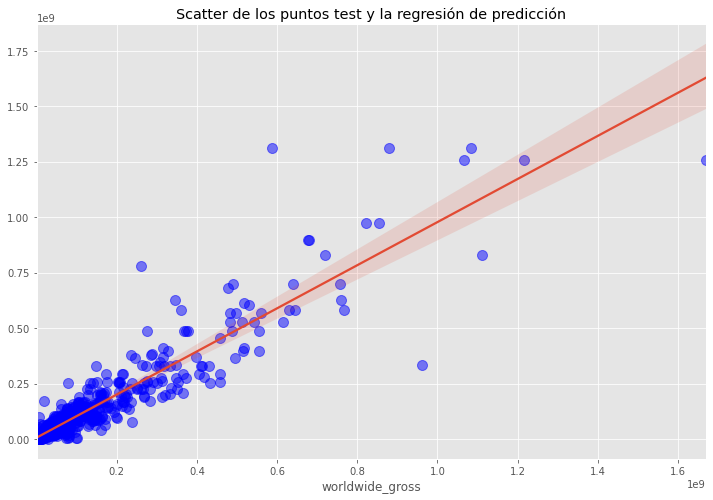

In [35]:
# Crear un vector de predicciones
y_pred_DT = model_DT.predict(X_test)

medida_error(y_pred_DT, y_test, model_DT)

# Bagging:   Random Forest

### Encontrar los parámetros óptimos

In [36]:
# Parámetros a ensayar
parameters = {'n_estimators':[100, 200, 300, 400],
              'max_depth':np.arange(3,15),
              'criterion':['mse', 'mae'],
              'max_features': ['auto', 'sqrt', 'log2']}

# Ensayando los parámetros en el modelo de regressión para obtener los más óptimos
model_RF = GridSearchCV(RandomForestRegressor(), parameters, cv=5, n_jobs=6)
model_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=6,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400]})

In [37]:
model_RF.best_params_

{'criterion': 'mae',
 'max_depth': 11,
 'max_features': 'auto',
 'n_estimators': 200}

In [38]:
# Se construye el Random Forest con los parámetros obtenidos
model_RF = RandomForestRegressor(n_estimators = model_RF.best_params_['n_estimators'],
                                 max_depth = model_RF.best_params_['max_depth'],
                                 criterion = model_RF.best_params_['criterion'], 
                                 max_features = model_RF.best_params_['max_features'])

model_RF.fit(X_train, y_train)

print('Entrenamiento del Random Forest: ', model_RF)

Entrenamiento del Random Forest:  RandomForestRegressor(criterion='mae', max_depth=11, n_estimators=200)


### Medidas del error para el modelo de Random Forest


R2 Score:  0.9300861887413481
MSE:  1958593324714917.0
Cross Validation Scores:  [0.57420825 0.77464666 0.75613684 0.84964994 0.54968102]
Promedio Cross Validation Score:  0.7008645454370466 



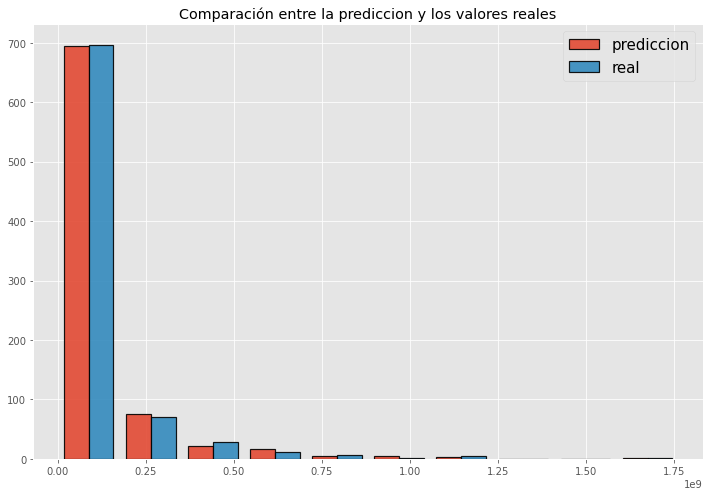

C:\Users\js-mu\anaconda3\envs\ia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


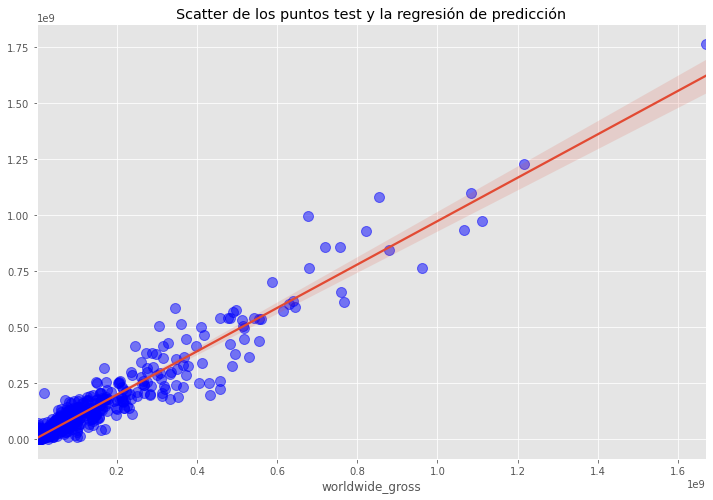

In [39]:
# Crear un vector de predicciones
y_pred_RF = model_RF.predict(X_test)

medida_error(y_pred_RF, y_test, model_RF)

# Boosting:  Gradient Boosting

### Encontrar los parámetros óptimos

In [40]:
# Parámetros a ensayar
parameters = {'n_estimators':[100, 200, 300],
              'max_depth':np.arange(3,15),
              'loss': ['ls', 'lad', 'huber', 'quantile'],
              "criterion": ["friedman_mse", "mse"]}
 
# Ensayando los parámetros en el modelo de regressión para obtener los más óptimos
model_GBT = GridSearchCV(GradientBoostingRegressor(), parameters, cv=5, n_jobs=6)
model_GBT.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=6,
             param_grid={'criterion': ['friedman_mse', 'mse'],
                         'loss': ['ls', 'lad', 'huber', 'quantile'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': [100, 200, 300]})

In [41]:
model_GBT.best_params_

{'criterion': 'mse', 'loss': 'ls', 'max_depth': 3, 'n_estimators': 300}

In [42]:
# Se construye el Gradient Boosting Tree con los parámetros obtenidos
model_GBT = GradientBoostingRegressor(n_estimators = model_GBT.best_params_['n_estimators'],
                                      max_depth = model_GBT.best_params_['max_depth'],
                                      loss = model_GBT.best_params_['loss'],
                                      criterion = model_GBT.best_params_['criterion'])

model_GBT.fit(X_train, y_train)

print('Entrenamiento del Gradient Boosting Tree: ', model_GBT)

Entrenamiento del Gradient Boosting Tree:  GradientBoostingRegressor(criterion='mse', n_estimators=300)


### Medidas del error para el modelo de Gradient Boosting Trees


R2 Score:  0.9177797402182477
MSE:  2303351069920938.5
Cross Validation Scores:  [0.63417677 0.80008099 0.75541331 0.81274443 0.60711065]
Promedio Cross Validation Score:  0.7219052308881326 



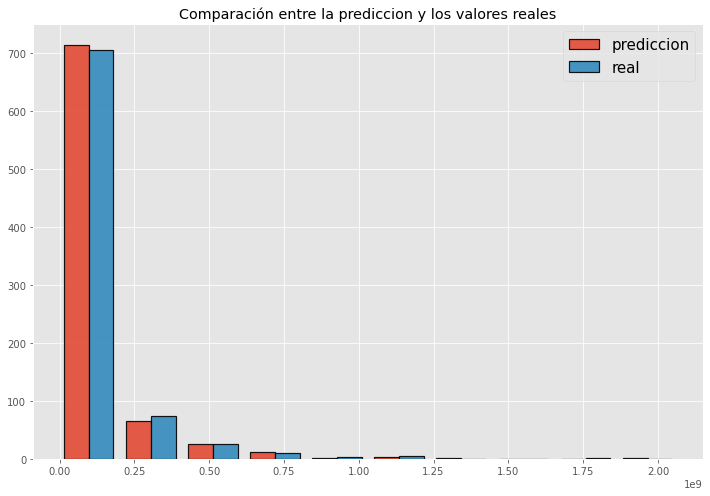

C:\Users\js-mu\anaconda3\envs\ia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


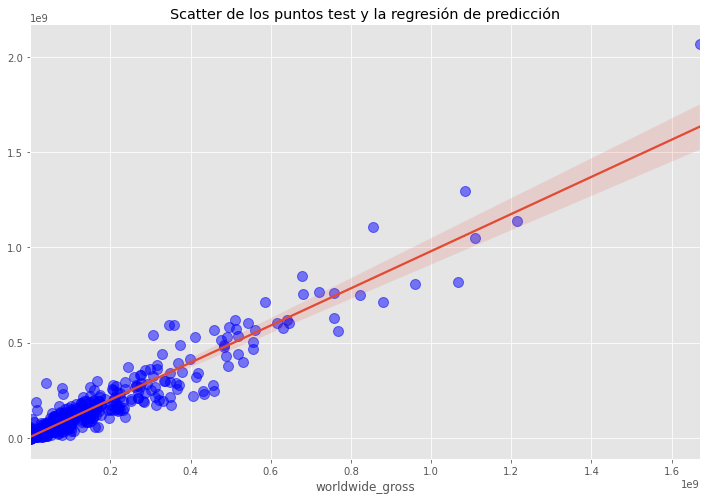

In [43]:
# Crear un vector de predicciones
y_pred_GBT = model_GBT.predict(X_test)

medida_error(y_pred_GBT, y_test, model_GBT)

# Boosting:   XGBoost

In [44]:
# Parámetros a ensayar
parameters = {'n_estimators':[100, 200, 300],
              'learning_rate':[0.001, 0.005, 0.1, 0.5],
              'booster': ['gbtree', 'gblinear']}

# Ensayando los parámetros en el modelo de regressión para obtener los más óptimos
model_XGB = GridSearchCV(xgb.XGBRegressor(), parameters, cv=5, n_jobs=6)
model_XGB.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [45]:
model_XGB.best_params_

{'booster': 'gbtree', 'learning_rate': 0.1, 'n_estimators': 100}

In [46]:
# Se construye el Gradient Boosting Tree con los parámetros obtenidos
model_XGB = xgb.XGBRegressor(n_estimators = model_XGB.best_params_['n_estimators'],
                             learning_rate = model_XGB.best_params_['learning_rate'],
                             booster = model_XGB.best_params_['booster'])


model_XGB.fit(X_train, y_train)

print('Entrenamiento del XGBoost: \n', model_XGB) 

Entrenamiento del XGBoost: 
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


### Medidas del error para el modelo de XGBoost


R2 Score:  0.9025429628531644
MSE:  2730200213175541.5
Cross Validation Scores:  [0.57658403 0.79319032 0.75814424 0.86496491 0.60536984]
Promedio Cross Validation Score:  0.7196506685858134 



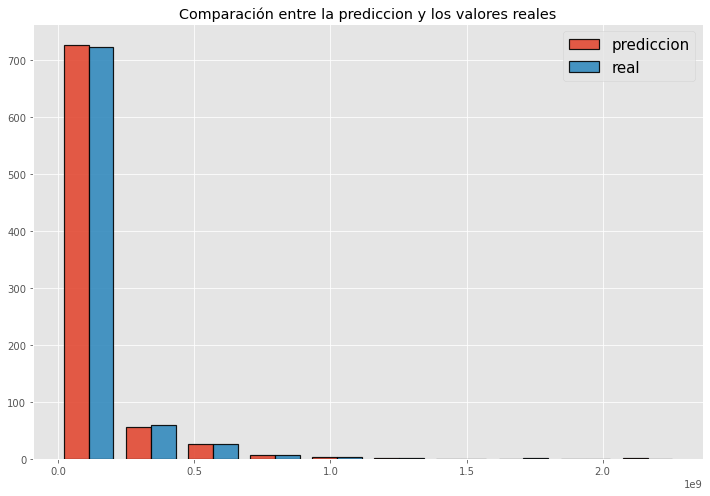

C:\Users\js-mu\anaconda3\envs\ia\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


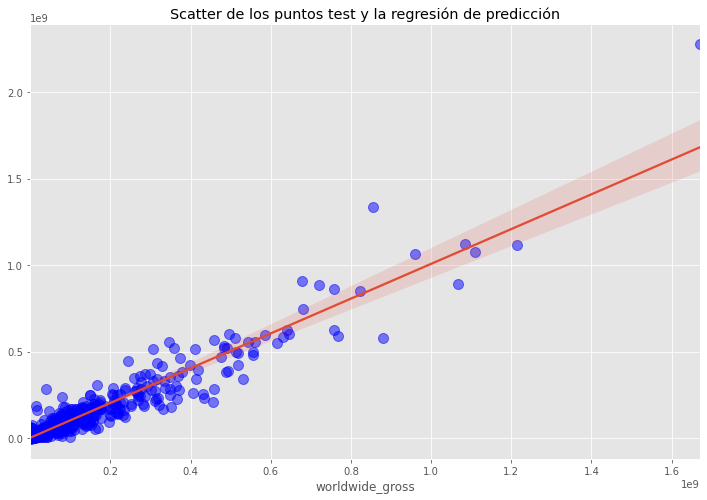

In [47]:
# Crear un vector de predicciones
y_pred_XGB = model_XGB.predict(X_test)

medida_error(y_pred_XGB, y_test, model_XGB)

## Analizando los residuales de la regresión para el modelo que obtuvo el mejor desempeño

### Se evidencia que los modelos de Boosting tienen mejor desempeño en la solución de este problema

- Mejor modelo: Gradient Boosting Tree
- Segundo Mejor modelo: XGBoost

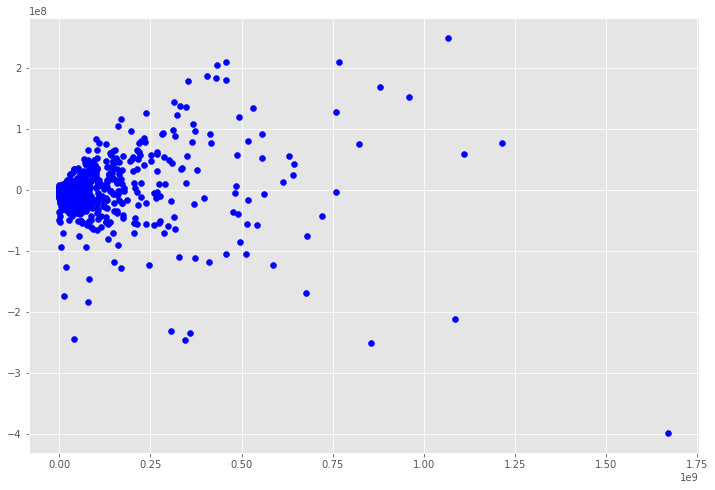

In [48]:
residuals = y_test - y_pred_GBT
plt.scatter(y_test, residuals, color='blue')
plt.show()

### Se observa que los residuales están en su mayoría, centrados en cero, por lo cual es buena la predicción la obtenida por el modelo. Aunque se debe buscar entender y organizar los valores alejados.

### Residuales en escala logarítmica

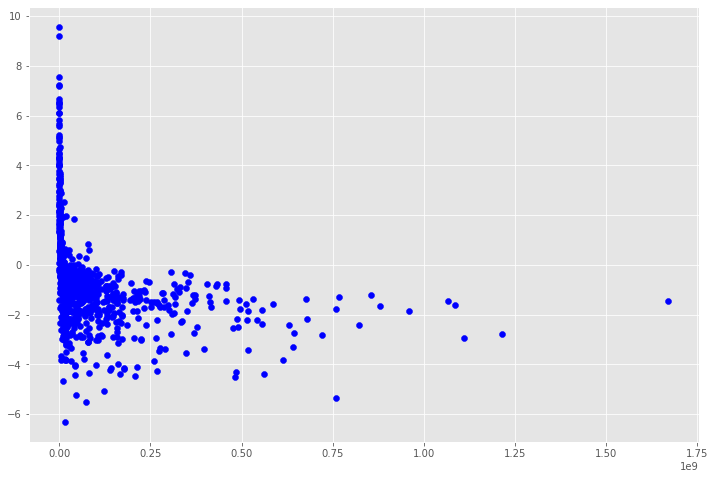

In [49]:
abs_residuals = np.abs(residuals) / y_test
log_abs_residuals = np.log(abs_residuals)
plt.scatter(y_test, log_abs_residuals, color='blue')
plt.show()

### Obtener y analizar los outliers

- considero como outliers aquellos que obtuvieron un ingreso mayor a 150 millones de dolares

In [50]:
df_movies.loc[df_clean_movies.index[X_test[residuals > 1.5e8].index]]

,movie_title,title_year,color,aspect_ratio,duration,language,country,duration.1,genres,content_rating,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,cast_total_facebook_likes,budget,imdb_score,gross
146,Mr. Peabody & Sherman,2014.0,Color,1.85,92.0,English,USA,92.0,Adventure|Animation|Comedy|Family|Sci-Fi,PG,dog|father son relationship|inventor|talking d...,Rob Minkoff,Ty Burrell,Zach Callison,Karan Brar,5810,145000000.0,6.9,111505642.0
2344,Regression,2015.0,Color,2.35,106.0,English,Spain,106.0,Crime|Drama|Mystery|Thriller,R,inspired by true events|memory|minnesota|polic...,Alejandro Amenábar,Emma Watson,Aaron Ashmore,Julian Richings,10982,NaN,5.7,54734.0
98,Godzilla Resurgence,2016.0,Color,2.35,120.0,Japanese,Japan,120.0,Action|Adventure|Drama|Horror|Sci-Fi,NaN,blood|godzilla|monster|sequel,Hideaki Anno,Mark Chinnery,Shin'ya Tsukamoto,Atsuko Maeda,699,NaN,8.2,NaN
20,The Hobbit: The Battle of the Five Armies,2014.0,Color,2.35,164.0,English,New Zealand,164.0,Adventure|Fantasy,PG-13,army|elf|hobbit|middle earth|orc,Peter Jackson,Aidan Turner,Adam Brown,James Nesbitt,9152,250000000.0,7.5,255108370.0
3,The Dark Knight Rises,2012.0,Color,2.35,164.0,English,USA,164.0,Action|Thriller,PG-13,deception|imprisonment|lawlessness|police offi...,Christopher Nolan,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,106759,250000000.0,8.5,448130642.0
2162,Beverly Hills Chihuahua,2008.0,Color,2.35,91.0,English,USA,91.0,Adventure|Comedy|Drama|Family|Romance,PG,chihuahua|german shepherd|mexico|potted plant|...,Raja Gosnell,Jamie Lee Curtis,Nick Zano,Ali Hillis,4729,20000000.0,3.7,94497271.0
1065,America's Sweethearts,2001.0,Color,2.35,102.0,English,USA,102.0,Comedy|Romance,PG-13,actor|love|movie star|press|publicist,Joe Roth,Julia Roberts,Rainn Wilson,Larry King,9176,48000000.0,5.7,93607673.0
189,War of the Worlds,2005.0,Color,1.85,116.0,English,USA,116.0,Adventure|Sci-Fi|Thriller,PG-13,alien|fight|storm|survival|tripod,Steven Spielberg,Tom Cruise,Lisa Ann Walter,Rick Gonzalez,12758,132000000.0,6.5,234277056.0
190,Bad Boys II,2003.0,Color,2.35,147.0,English,USA,147.0,Action|Comedy|Crime|Thriller,R,cuba|dea|drugs|money|undercover,Michael Bay,Will Smith,Henry Rollins,Jordi Mollà,12954,130000000.0,6.6,138396624.0
74,Evan Almighty,2007.0,Color,2.35,96.0,English,USA,96.0,Comedy|Family|Fantasy,PG,ark|change|congressman|depiction of god|flood,Tom Shadyac,Jimmy Bennett,Morgan Freeman,Steve Carell,108016,175000000.0,5.4,100289690.0


### Estos outliers corresponden a algunas películas que obtuvieron grandes ingresos.
- La mayoría de estas películas fueron los mayores éxitos del cine hasta el año 2016.
- Algunas otras fueron peliculas de bajo presupuesto que lograron grandes ganancias, se supone que son éxitos del cine independiente ya que estos suceden con menor frecuencia.